# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Ridge and Lasso) to predict house prices.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: ROC/ AUC curves, accuracy, precision, F1-score, R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Determine the best regression model for price prediction.
- Convert categorical data to numerical data.
- Evaluate the effect of scaling/ normalization on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [132]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [133]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## Planning

I will run Regression models for several different 'passes' which each use different feature datasets.

Each pass gets these steps:

1. Determine input data
2. Import, instantiate, and fit models - linear, lasso, ridge
3. Predicting target variables
4. Evaluating predictions vs. test data
5. K-fold cross validation
6. Hyperparameter tuning
7. Pipeline for best model

Afterwards I can do more advanced things - scaling, categorical -> numeric, other metrics, PCA

Input data ideas:

- [x] Pass 1 = only square meters
- [] Pass 2 = only numeric data
- [] Pass 3 = numeric data plus some categoric data converted to numeric - only the Neighborhood column
- [] Intermediate run = numeric data plus some categoric data converted to numeric - only those columns which are T/F
- [] Final run through = _all_ data

Other ideas: add price per square meter column, add other features?

In [134]:
from sklearn.model_selection import train_test_split

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## -------------------- Pass 1 - Only Square Meters --------------------
1. Get data
2. Simple test models - pick 1 hyperparam, instantiate, fit, score, predict and plot predictions
3. k-fold cross validation - setup k-Fold data, apply `cross_val_score`, boxplot the results
4. Hyperparameter tuning - setup param grids, setup RandomizedSearchCV object, fit, print score, best score and best params

### 1.1 Get data

In [135]:
# Create sqm-only dataset
X_sqm = housing_df['Square Meters'].values.reshape(-1, 1)
y = housing_df['Price (£)'].values
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(700, 1) (300, 1) (700,) (300,)


### 1.1 Simple models

#### 1.2.1 Instantiate and fit

In [13]:
# Instantiate models
linreg1 = LinearRegression()
lasso1 = Lasso(alpha = 0.1)
ridge1 = Ridge(alpha = 0.1)

# Fit to numeric data
linreg1.fit(X_train_sqm, y_train_sqm)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [136]:
lasso1.fit(X_train_sqm, y_train_sqm)


,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [137]:
ridge1.fit(X_train_sqm, y_train_sqm)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [138]:
# Create a model dictionary
models_sqm = {
    'Linear Regression': linreg1,
    'Lasso': lasso1,
    'Ridge': ridge1
}

#### 1.2.3 Predict and plot

In [153]:
def score_predict_plot(model_dict, X_test, y_test, title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, label='Actual', color='black', alpha=0.9, s=20)
    
    # Loop over models and plot their restults
    for model_name, model in model_dict.items():
        # Generate predictions
        y_pred = model.predict(X_test)
        # Print model score
        print(f"{model_name} Score (R²): {model.score(X_test, y_test):.4f}")
        # Scatter plot predictions vs actual
        plt.scatter(X_test, y_pred, label=model_name, alpha=0.5, s=20)
        
    # Labels and title
    plt.xlabel('X test', fontsize=11)
    plt.ylabel('Target results [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Linear Regression Score (R²): 0.5912
Ridge Score (R²): 0.5912
Lasso Score (R²): 0.5912


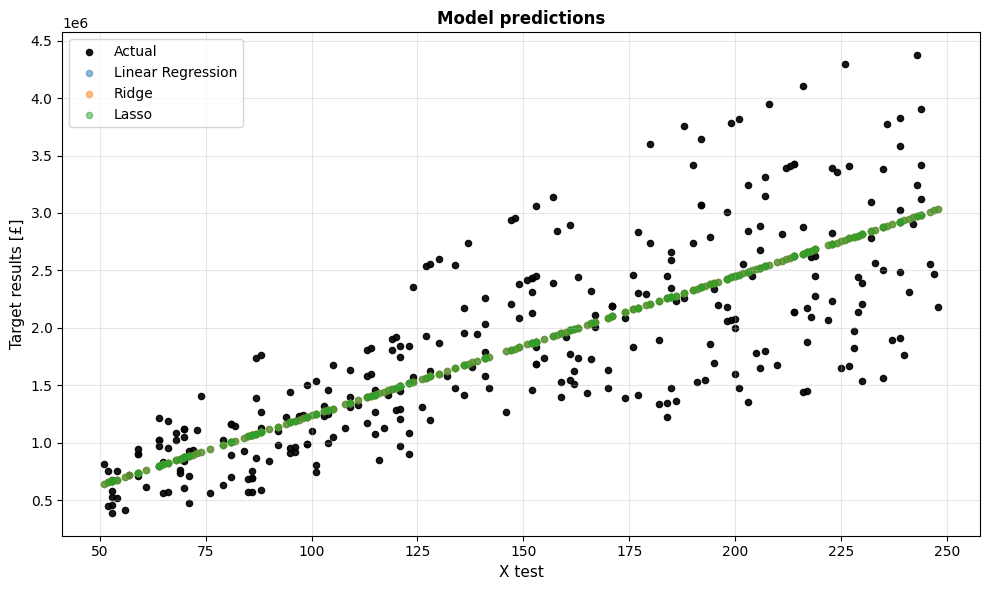

In [154]:
models = {
    'Linear Regression': linreg1,
    'Ridge': ridge1,
    'Lasso': lasso1
}

score_predict_plot(models, X_test_sqm, y_test_sqm)

### 1.3 Cross validation

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

In [155]:
# Create k-fold object
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
kf5 = KFold(n_splits=5, shuffle=True, random_state=24)
kf10 = KFold(n_splits=10, shuffle=True, random_state=24)

In [156]:
def multi_cross_val_score(models, X, y, kf):
    """Function to return cross-validation scores for multiple models."""
    cross_val_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf)
        cross_val_scores[name] = scores
        print(f'{name} cross-validation scores: {np.round(np.min(cv_ridge1), 3)} --- {np.round(np.mean(cv_ridge1), 3)} --- {np.round(np.max(cv_ridge1), 3)}')
    return cross_val_scores

In [157]:
cross_vals_sqm = multi_cross_val_score(
    models = {'Linear Regression': linreg1, 'Lasso': lasso1, 'Ridge': ridge1},
    X = X_train_sqm,
    y = y_train_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.63 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.63 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.63 --- 0.698


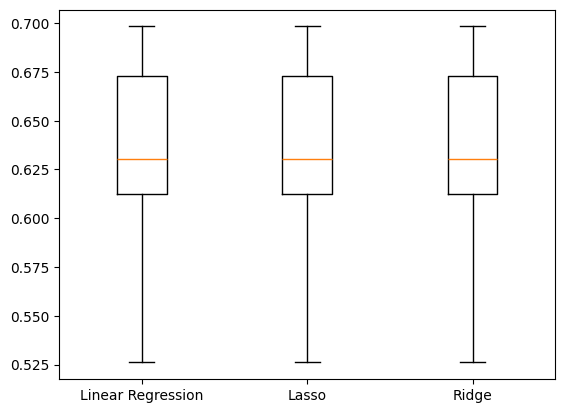

In [158]:
plt.boxplot(
    [model_result for model_result in cross_vals_sqm.values()],
    labels = [model_name for model_name in cross_vals_sqm.keys()]
)
plt.show()

#### 1.4 Hyperparameter tuning

#### 1.4.1 GridSearchCV

Instantiate and fit

In [92]:
# Instantiate GridSearchCVs
gridCV_lasso1 = GridSearchCV(lasso1, lasso_params, cv=kf10)
gridCV_ridge1 = GridSearchCV(ridge1, ridge_params, cv=kf10)
# Fit GridSearchCVs
gridCV_lasso1.fit(X_train_sqm, y_train_sqm)
gridCV_ridge1.fit(X_train_sqm, y_train_sqm)

,estimator,Ridge(alpha=0.1)
,param_grid,"{'alpha': array([1.000e...1, 1.000e+00]), 'solver': ['sag', 'lsqr']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.8889


Score

In [93]:
# Basic scoring - GridSearchCV models
print(f'Lasso score: {gridCV_lasso1.score(X_test_sqm, y_test_sqm)}')
print(f'Ridge score: {gridCV_ridge1.score(X_test_sqm, y_test_sqm)}')
# Best parameters and scores - GridSearchCV models
print(f'Lasso GridSearchCV top score: {gridCV_lasso1.best_score_} from {gridCV_lasso1.best_params_}')
print(f'Ridge GridSearchCV top score: {gridCV_ridge1.best_score_} from {gridCV_ridge1.best_params_}')

Lasso score: 0.5912280013415312
Ridge score: 0.5912591467450596
Lasso GridSearchCV top score: 0.629566861606362 from {'alpha': 1.0}
Ridge GridSearchCV top score: 0.6296282351041593 from {'alpha': 0.8889, 'solver': 'sag'}


#### 1.4.2 RandomSearchCV

In [159]:
# Instantiate RandomizedSearchCVs
randomCV_lasso1 = RandomizedSearchCV(lasso1, lasso_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge1 = RandomizedSearchCV(ridge1, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Fit RandomizedSearchCVs
randomCV_lasso1.fit(X_train_sqm, y_train_sqm)
randomCV_ridge1.fit(X_train_sqm, y_train_sqm)

,estimator,Ridge(alpha=0.1)
,param_distributions,"{'alpha': array([1.000e...1, 1.000e+00]), 'solver': ['sag', 'lsqr']}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


Score

In [87]:
# Scoring - RandomizedSearchCV models
# Lasso
print(f'Lasso score: {randomCV_lasso1.score(X_test_sqm, y_test_sqm)}')
print(f'Lasso RandomizedSearchCV top score: {randomCV_lasso1.best_score_} from {randomCV_lasso1.best_params_}')
# Ridge
print(f'Ridge score: {randomCV_ridge1.score(X_test_sqm, y_test_sqm)}')
print(f'Ridge RandomizedSearchCV top score: {randomCV_ridge1.best_score_} from {randomCV_ridge1.best_params_}')

Lasso score: 0.5912280013415312
Lasso RandomizedSearchCV top score: 0.629566861606362 from {'alpha': 1.0}
Ridge score: 0.5912184264995735
Ridge RandomizedSearchCV top score: 0.6295797366371748 from {'solver': 'sag', 'alpha': 0.0001}


In [95]:
# Lasso
lasso_sqm_special = Lasso(alpha = 1)
lasso_sqm_special.fit(X_train_sqm, y_train_sqm)
print(f'Lasso special: {lasso_sqm_special.score(X_test_sqm, y_test_sqm)}')
# Ridge
ridge_sqm_special = Ridge(alpha = 1)
ridge_sqm_special.fit(X_train_sqm, y_train_sqm)
print(f'Ridge special: {ridge_sqm_special.score(X_test_sqm, y_test_sqm)}')

Lasso special: 0.5912280013415312
Ridge special: 0.5912280261696814


### 1.6 Scaling
Can the score be increased through Standard Scaling?

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge1 = Pipeline(steps)

ridge1_scaled = pipeline_ridge1.fit(X_train_sqm, y_train_sqm)

In [108]:
ridge1_scaled.score(X_test_sqm, y_test_sqm)

0.5913154197136332

Adding in CVs

In [115]:
lasso_params2 = {'alpha': np.linspace(0.0001, 1, 10)}
ridge_params2 = {'ridge__alpha': np.linspace(0.0001, 1, 10),
                'ridge__solver': ['sag', 'lsqr']}

In [123]:
# Instantiate GridSearchCVs
gridCV_ridge1_scaled = GridSearchCV(ridge1_scaled, param_grid=ridge_params2, cv=kf10)
# Fit GridSearchCVs
gridCV_ridge1_scaled.fit(X_train_sqm, y_train_sqm)

# Score GridSearchCV models
print(f'Ridge score: {gridCV_ridge1_scaled.score(X_test_sqm, y_test_sqm)}')
print(f'Scaled Ridge GridSearchCV top score: {gridCV_ridge1_scaled.best_score_} from {gridCV_ridge1_scaled.best_params_}')

Ridge score: 0.5912702565225064
Scaled Ridge GridSearchCV top score: 0.6300916879184014 from {'ridge__alpha': 0.5556, 'ridge__solver': 'sag'}


### 1.6 Pass 1 - what have we learned?

1. Simple models: each of Linear, Lasso and Ridge Regression each get 59% accuracy --> Quite poor
    - Each model seems to be making exactly the same predictions
2. 5-Fold cross-validation: the scores range from 59-66% (average 63%)
3. 10-Fold cross-validation: the scores range from 53-70% (average 63%)
4. GridSearchCV over alpha: best parameters get 63% at alpha=1 (Ridge and Lasso are equal, RandomizedSearchCV gives basically the same results)
5. Nothing gained from scaling

## -------------------- Pass 2 - Numeric data --------------------

### 2.1 Get Data

In [75]:
# Create numeric-only dataset
numeric_columns = ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']
X_numeric = housing_df.loc[:, numeric_columns].values
y = housing_df['Price (£)'].values
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.3, random_state=24)

print(X_train_numeric.shape, X_test_numeric.shape, y_train_numeric.shape, y_test_numeric.shape)

(700, 5) (300, 5) (700,) (300,)


### 2.2 Import, instantiate, fit

Linear, lasso and ridge regression model

In [76]:
# Instantiate models
linreg = LinearRegression()
lasso = Lasso(alpha = 0.1)
ridge = Ridge(alpha = 0.1)

# Fit to numeric data
linreg.fit(X_train_numeric, y_train_numeric)
lasso.fit(X_train_numeric, y_train_numeric)
ridge.fit(X_train_numeric, y_train_numeric)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


### 2.3 Predict

In [79]:
y_linreg = linreg.predict(X_test_numeric)
y_lasso = lasso.predict(X_test_numeric)
y_ridge = ridge.predict(X_test_numeric)

print(f'Linear predictions: {y_linreg.shape}')
print(f'Lasso predictions: {y_lasso.shape}')
print(f'Ridge predictions: {y_ridge.shape}')

Linear predictions: (300,)
Lasso predictions: (300,)
Ridge predictions: (300,)


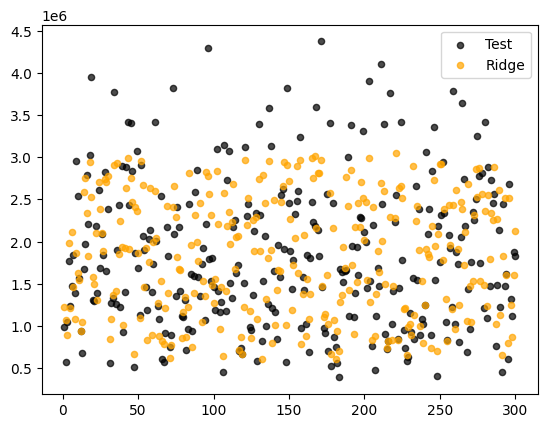

In [107]:
y_points = np.linspace(1, len(y_test_numeric), len(y_test_numeric))
# print(len(y_points))
plt.scatter(y_points, y_test_numeric, label='Test', alpha=0.7, color='black', s=20)
# plt.scatter(y_points, y_linreg, label='LinReg', alpha=0.7, color='blue', s=20)
# plt.scatter(y_points, y_lasso, label='Lasso', alpha=0.7, color='green', s=20)
plt.scatter(y_points, y_ridge, label='Ridge', alpha=0.7, color='orange', s=20)
plt.legend()
plt.show()

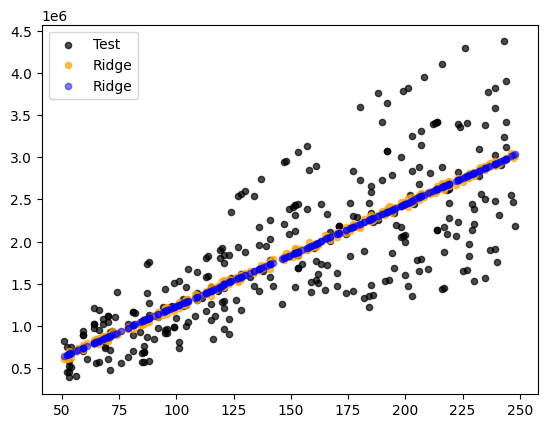

In [108]:
plt.scatter(X_test_numeric[:, 2], y_test_numeric, label='Test', alpha=0.7, color='black', s=20)
# plt.scatter(X_test_numeric[:, 2], y_linreg, label='LinReg', alpha=0.7, color='blue', s=20)
# plt.scatter(X_test_numeric[:, 2], y_lasso, label='Lasso', alpha=0.7, color='green', s=20)
plt.scatter(X_test_numeric[:, 2], y_ridge, label='Ridge', alpha=0.7, color='orange', s=20)
plt.scatter(X_test_sqm, ridge1_preds, label='Ridge', alpha=0.5, color='blue', s=20)
plt.legend()
plt.show()